In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')

In [5]:
TS_COL = 'connected_time_start_ts'
LOCATION_COL = 'location_name'

FORECAST_MONTHS = 1

CAT_PARAMS = {
    'iterations': 1000,
    'learning_rate': 0.04,
    'depth': 6,
    'loss_function': 'RMSE',
    'verbose': 100
}

In [60]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [61]:
try:
    df = pd.read_csv('/content/drive/MyDrive/DSP Project Data/Time_Series_Input.csv')
    print('Data loaded successfully!')
except FileNotFoundError:
    print("Error: The file was not found. Please check the path.")
except Exception as e:
    print(f"An error occurred: {e}")

df.drop(columns = 'Unnamed: 0', inplace = True)
df[TS_COL] = pd.to_datetime(df[TS_COL])

Data loaded successfully!


In [14]:
df.head(2)

,date,location_name,charge_duration_min,connected_duration_min,energy_provided_kwh,session_status,connected_time_start_ts,locality,temp,tempmax,tempmin,humidity,conditions,charge_duration_hours,days_between_charges,connected_slot,disconnected_slot,log_charge_duration,log_energy_kwh,log_connected_duration,energy_per_min,overstay_ratio,charge_rate_kw
0,2025-05-23,QFA - QUEENS FAMILY COURT MUNICIPAL GARAGE,200.316667,200.316667,15.277,ROAMING,2025-05-23 07:21:35,QUEENS,54.1,63.6,48.6,75.5,"Rain, Overcast",3.0,0.0,morning,morning,5.304879,2.789753,5.304879,0.076264,0.0,4.575855
1,2025-07-13,QFA - QUEENS FAMILY COURT MUNICIPAL GARAGE,3.666667,3.666667,0.364,ROAMING,2025-07-13 16:43:23,QUEENS,76.7,81.9,72.2,79.7,"Rain, Partially cloudy",0.0,51.0,afternoon,afternoon,1.540445,0.310422,1.540445,0.099273,0.0,5.956364


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206868 entries, 0 to 206867
Data columns (total 23 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   date                     206868 non-null  object        
 1   location_name            206868 non-null  object        
 2   charge_duration_min      206868 non-null  float64       
 3   connected_duration_min   206868 non-null  float64       
 4   energy_provided_kwh      206868 non-null  float64       
 5   session_status           206868 non-null  object        
 6   connected_time_start_ts  206868 non-null  datetime64[ns]
 7   locality                 206868 non-null  object        
 8   temp                     206868 non-null  float64       
 9   tempmax                  206868 non-null  float64       
 10  tempmin                  206868 non-null  float64       
 11  humidity                 206868 non-null  float64       
 12  conditions      

In [62]:
#Retaining useful column identiofed from EDA
keep_cols = [TS_COL, LOCATION_COL, 'energy_provided_kwh', 'charge_duration_min', 'connected_duration_min', 'temp', 'humidity', 'conditions']
keep_cols = [c for c in keep_cols if c in df.columns]

df = df[keep_cols].copy()

In [63]:
#Adding hour column for time series analysis
df['hour'] = df[TS_COL].dt.floor('H')

In [64]:
agg = df.groupby([LOCATION_COL, 'hour']).agg(
    sessions_per_hour = (TS_COL, 'count'),
    energy_kwh_per_hour = ('energy_provided_kwh', 'sum'),
    avg_charge_duration = ('charge_duration_min','mean'),
    avg_connected_duration = ('connected_duration_min','mean'),
    avg_temp = ('temp','mean'),
    avg_humidity = ('humidity','mean')
).reset_index()

print('Aggregated hourly shape:', agg.shape)

Aggregated hourly shape: (94146, 8)


In [65]:
full_start = agg['hour'].min()
full_end = agg['hour'].max()

print(f'Full start: {full_start}')
print(f'Full end: {full_end}')

Full start: 2021-07-31 09:00:00
Full end: 2025-11-27 04:00:00


In [68]:
#Creating a new dataframe with all the hour info index present for this period. Missing values will be filled with 0
full_range = pd.date_range(start=full_start, end=full_end, freq='H')
locations = agg[LOCATION_COL].unique()

full_idx = pd.MultiIndex.from_product([locations, full_range], names=[LOCATION_COL, 'hour'])

hourly = agg.set_index([LOCATION_COL, 'hour']).reindex(full_idx).reset_index()

#Handling mising values
hourly['sessions_per_hour'] = hourly['sessions_per_hour'].fillna(0)
hourly['energy_kwh_per_hour'] = hourly['energy_kwh_per_hour'].fillna(0)

#Moving from last/next hour
for col in ['avg_charge_duration','avg_connected_duration','avg_temp','avg_humidity']:
    if col in hourly.columns:
        hourly[col] = hourly.groupby(LOCATION_COL)[col].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))

In [69]:
hourly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606656 entries, 0 to 606655
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   location_name           606656 non-null  object        
 1   hour                    606656 non-null  datetime64[ns]
 2   sessions_per_hour       606656 non-null  float64       
 3   energy_kwh_per_hour     606656 non-null  float64       
 4   avg_charge_duration     606656 non-null  float64       
 5   avg_connected_duration  606656 non-null  float64       
 6   avg_temp                606656 non-null  float64       
 7   avg_humidity            606656 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 37.0+ MB


In [70]:
hourly.head(3)

,location_name,hour,sessions_per_hour,energy_kwh_per_hour,avg_charge_duration,avg_connected_duration,avg_temp,avg_humidity
0,BAY RIDGE MUNICIPAL PARKING GARAGE,2021-07-31 09:00:00,0.0,0.0,325.046233,948.90725,70.6,47.9
1,BAY RIDGE MUNICIPAL PARKING GARAGE,2021-07-31 10:00:00,0.0,0.0,325.046233,948.90725,70.6,47.9
2,BAY RIDGE MUNICIPAL PARKING GARAGE,2021-07-31 11:00:00,0.0,0.0,325.046233,948.90725,70.6,47.9


In [71]:
print('Hourly matrix shape:', hourly.shape)

Hourly matrix shape: (606656, 8)


In [72]:
#Adding time related features
hourly['hour_of_day'] = hourly['hour'].dt.hour
hourly['day_of_week'] = hourly['hour'].dt.dayofweek
hourly['month'] = hourly['hour'].dt.month
hourly['is_weekend'] = hourly['day_of_week'].isin([5,6]).astype(int)

In [73]:
#Adding weather related features
hourly['is_hot'] = (hourly['avg_temp'] > 30).astype(int)
hourly['is_cold'] = (hourly['avg_temp'] < 5).astype(int)

cond = df.groupby([LOCATION_COL, 'hour'])['conditions'].agg(lambda x: x.mode().iloc[0] if len(x.dropna())>0 else np.nan).reset_index()
hourly = hourly.merge(cond, on=[LOCATION_COL,'hour'], how='left')
hourly['is_rainy'] = hourly['conditions'].str.contains('Rain|Drizzle', case=False, na=False).astype(int)
hourly['is_snow'] = hourly['conditions'].str.contains('Snow', case=False, na=False).astype(int)

In [74]:
hourly = hourly.sort_values([LOCATION_COL,'hour'])

In [75]:
#Adding lag features for predcitions
for tgt in ['sessions_per_hour','energy_kwh_per_hour']:
    hourly[f'{tgt}_lag1'] = hourly.groupby(LOCATION_COL)[tgt].shift(1)
    hourly[f'{tgt}_lag24'] = hourly.groupby(LOCATION_COL)[tgt].shift(24)
    hourly[f'{tgt}_lag168'] = hourly.groupby(LOCATION_COL)[tgt].shift(168)
    hourly[f'{tgt}_ma24'] = hourly.groupby(LOCATION_COL)[tgt].rolling(24).mean().reset_index(0,drop=True)

hourly.fillna({c:0 for c in hourly.columns if c.endswith('_lag1') or c.endswith('_lag24') or c.endswith('_lag168') or c.endswith('_ma24')}, inplace=True)

In [76]:
hourly.head(3)

,location_name,hour,sessions_per_hour,energy_kwh_per_hour,avg_charge_duration,avg_connected_duration,avg_temp,avg_humidity,hour_of_day,day_of_week,month,is_weekend,is_hot,is_cold,conditions,is_rainy,is_snow,sessions_per_hour_lag1,sessions_per_hour_lag24,sessions_per_hour_lag168,sessions_per_hour_ma24,energy_kwh_per_hour_lag1,energy_kwh_per_hour_lag24,energy_kwh_per_hour_lag168,energy_kwh_per_hour_ma24
0,BAY RIDGE MUNICIPAL PARKING GARAGE,2021-07-31 09:00:00,0.0,0.0,325.046233,948.90725,70.6,47.9,9,5,7,1,1,0,NaN,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,BAY RIDGE MUNICIPAL PARKING GARAGE,2021-07-31 10:00:00,0.0,0.0,325.046233,948.90725,70.6,47.9,10,5,7,1,1,0,NaN,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,BAY RIDGE MUNICIPAL PARKING GARAGE,2021-07-31 11:00:00,0.0,0.0,325.046233,948.90725,70.6,47.9,11,5,7,1,1,0,NaN,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
#Plotting global session trends

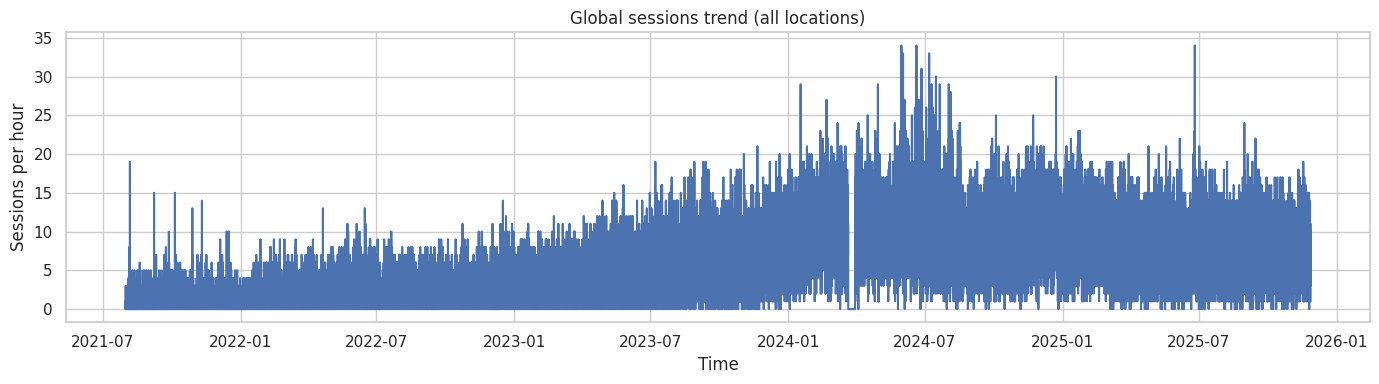

In [77]:
agg_total = hourly.groupby('hour').agg(
    sessions_total=('sessions_per_hour','sum'),
    energy_total=('energy_kwh_per_hour','sum')
).reset_index()

plt.figure(figsize=(14,4))
plt.plot(agg_total['hour'], agg_total['sessions_total'])
plt.title('Global sessions trend (all locations)')
plt.xlabel('Time')
plt.ylabel('Sessions per hour')
plt.tight_layout()

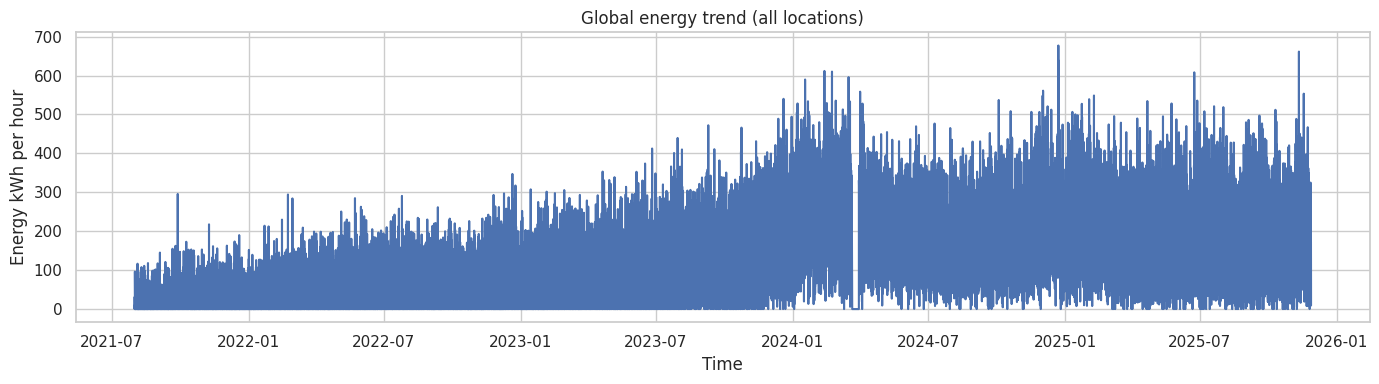

In [78]:
plt.figure(figsize=(14,4))
plt.plot(agg_total['hour'], agg_total['energy_total'])
plt.title('Global energy trend (all locations)')
plt.xlabel('Time')
plt.ylabel('Energy kWh per hour')
plt.tight_layout()

In [79]:
# Daily seasonality (hour of day)
daily = hourly.groupby('hour_of_day')['sessions_per_hour'].mean()

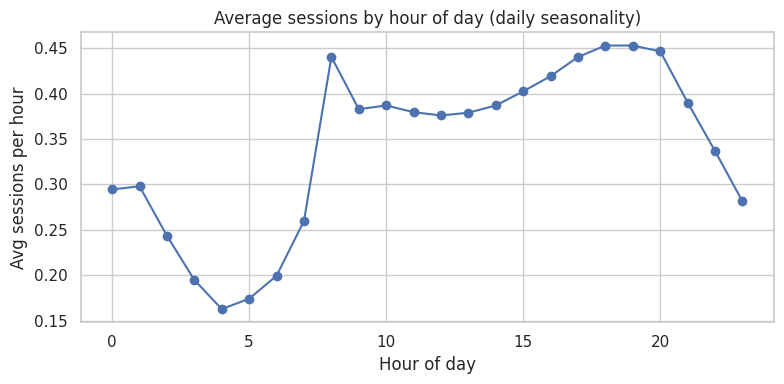

In [43]:
plt.figure(figsize=(8,4))
plt.plot(daily.index, daily.values, marker='o')
plt.title('Average sessions by hour of day (daily seasonality)')
plt.xlabel('Hour of day')
plt.ylabel('Avg sessions per hour')
plt.grid(True)
plt.tight_layout()

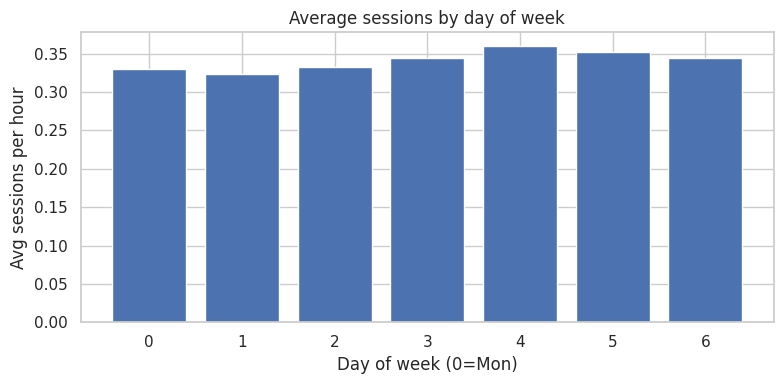

In [44]:
# Weekly seasonality (day of week)
weekly = hourly.groupby('day_of_week')['sessions_per_hour'].mean()
plt.figure(figsize=(8,4))
plt.bar(weekly.index, weekly.values)
plt.title('Average sessions by day of week')
plt.xlabel('Day of week (0=Mon)')
plt.ylabel('Avg sessions per hour')
plt.tight_layout()

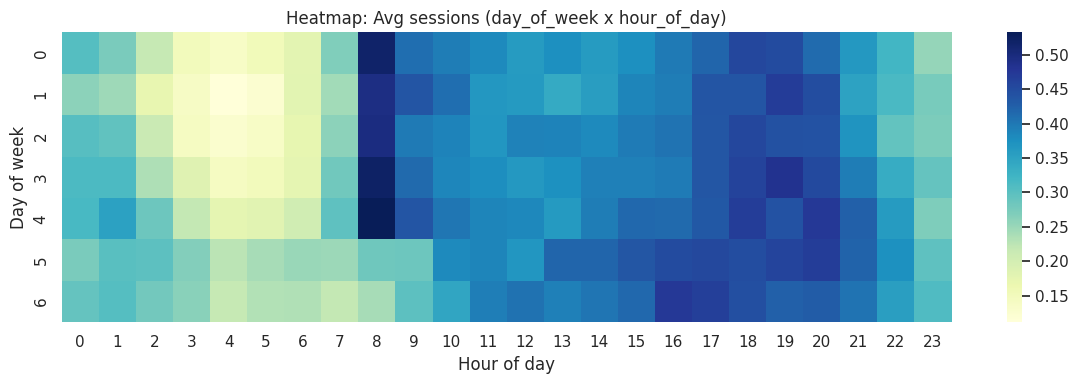

In [45]:
# Heatmap: average hour-of-day by day-of-week (pivot)
pivot = hourly.pivot_table(index='day_of_week', columns='hour_of_day', values='sessions_per_hour', aggfunc='mean').fillna(0)
plt.figure(figsize=(12,4))
sns.heatmap(pivot, cmap='YlGnBu')
plt.title('Heatmap: Avg sessions (day_of_week x hour_of_day)')
plt.xlabel('Hour of day')
plt.ylabel('Day of week')
plt.tight_layout()

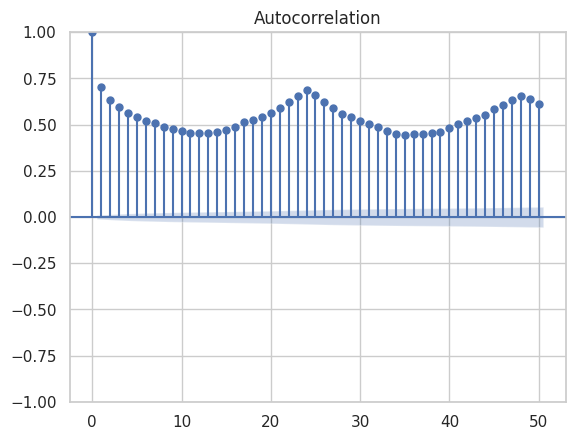

<Figure size 1000x300 with 0 Axes>

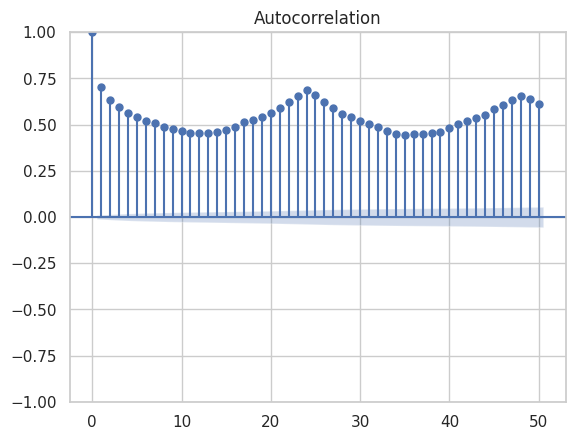

In [46]:
series_acf = agg_total['sessions_total'].dropna()
plt.figure(figsize=(10,3))
plot_acf(series_acf, lags=50)

<Figure size 1000x300 with 0 Axes>

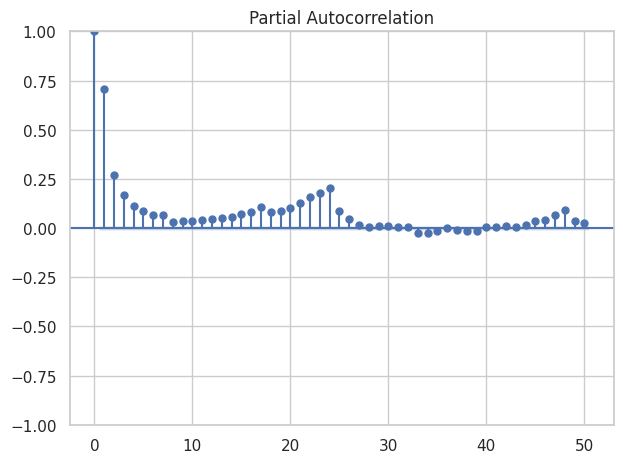

In [47]:
plt.figure(figsize=(10,3))
plot_pacf(series_acf, lags=50)
plt.tight_layout()

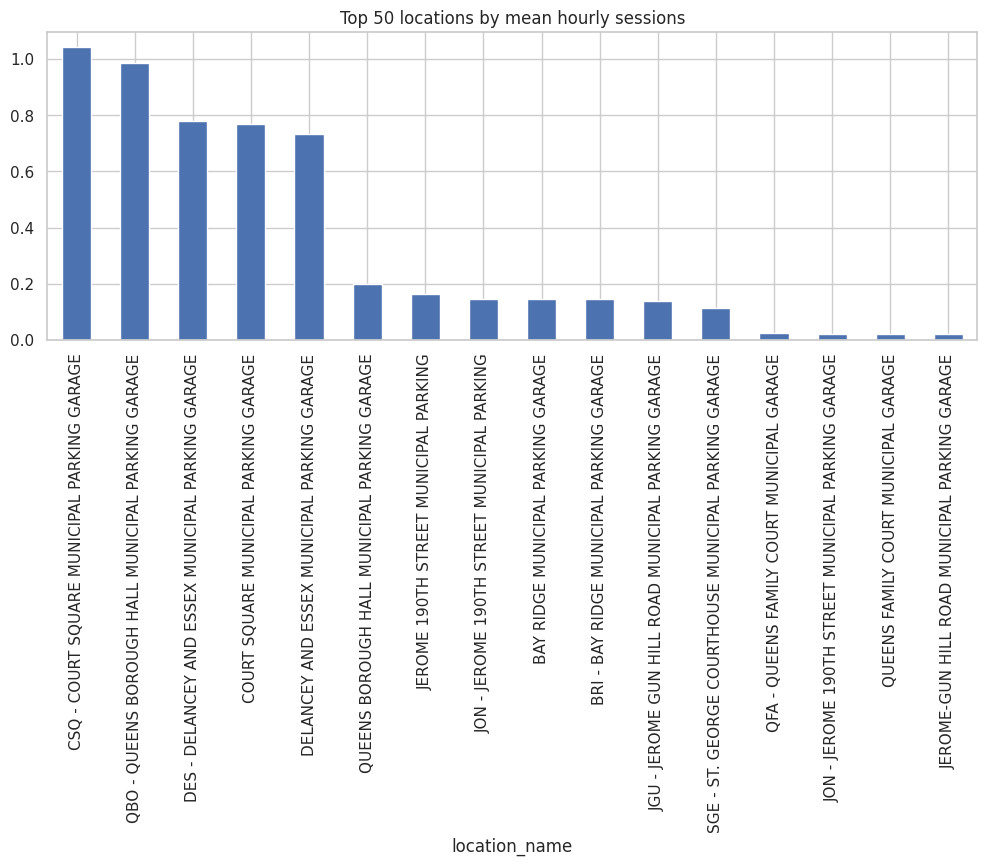

In [48]:
station_stats = hourly.groupby(LOCATION_COL)['sessions_per_hour'].agg(['mean','median','std','count'])
station_stats = station_stats.sort_values('mean', ascending=False)

plt.figure(figsize=(12,4))
station_stats['mean'].head(50).plot(kind='bar')
plt.title('Top 50 locations by mean hourly sessions')
plt.tight_layout()

In [80]:
#Splitting into train-test
max_hour = hourly['hour'].max()
forecast_end = max_hour + pd.DateOffset(months=FORECAST_MONTHS)
cutoff = max_hour - pd.DateOffset(months=FORECAST_MONTHS)  # train until 6 months before end

train = hourly[hourly['hour'] <= cutoff].copy()
valid = hourly[(hourly['hour'] > cutoff) & (hourly['hour'] <= max_hour)].copy()

print('Train rows:', train.shape[0], 'Validation rows:', valid.shape[0])

Train rows: 594752 Validation rows: 11904


In [50]:
FEATURES = [
    'hour_of_day','day_of_week','month','is_weekend',
    'is_hot','is_cold','is_rainy','is_snow',
    'sessions_per_hour_lag1','sessions_per_hour_lag24','sessions_per_hour_lag168','sessions_per_hour_ma24',
    'energy_kwh_per_hour_lag1','energy_kwh_per_hour_lag24','energy_kwh_per_hour_lag168','energy_kwh_per_hour_ma24'
]

In [51]:
CAT_FEATS = [LOCATION_COL]
CAT_FEATS

['location_name']

In [52]:
print('\nTraining sessions_per_hour model...')
model_sessions = CatBoostRegressor(**CAT_PARAMS)
model_sessions.fit(train[FEATURES + [LOCATION_COL]], train['sessions_per_hour'], cat_features=CAT_FEATS)


Training sessions_per_hour model...
0:	learn: 0.9987486	total: 661ms	remaining: 11m
100:	learn: 0.6164669	total: 28s	remaining: 4m 9s
200:	learn: 0.6091696	total: 58.1s	remaining: 3m 50s
300:	learn: 0.6040693	total: 1m 24s	remaining: 3m 17s
400:	learn: 0.6001866	total: 1m 52s	remaining: 2m 47s
500:	learn: 0.5972723	total: 2m 17s	remaining: 2m 17s
600:	learn: 0.5945328	total: 2m 42s	remaining: 1m 47s
700:	learn: 0.5920128	total: 3m 6s	remaining: 1m 19s
800:	learn: 0.5898988	total: 3m 31s	remaining: 52.6s
900:	learn: 0.5879264	total: 3m 56s	remaining: 26s
999:	learn: 0.5863085	total: 4m 19s	remaining: 0us


In [88]:
# validate
pred_valid_sessions = model_sessions.predict(valid[FEATURES + [LOCATION_COL]])
print('Sessions MAE:', mean_absolute_error(valid['sessions_per_hour'], pred_valid_sessions))
print('Sessions RMSE:', rmse(valid['sessions_per_hour'], pred_valid_sessions))

Sessions MAE: 0.29485116585460436
Sessions RMSE: 0.6842893714310103


In [54]:
# train for energy
print('\nTraining energy_kwh_per_hour model...')
model_energy = CatBoostRegressor(**CAT_PARAMS)
model_energy.fit(train[FEATURES + [LOCATION_COL]], train['energy_kwh_per_hour'], cat_features=CAT_FEATS)


Training energy_kwh_per_hour model...
0:	learn: 22.6910386	total: 340ms	remaining: 5m 39s
100:	learn: 14.6558170	total: 29.9s	remaining: 4m 26s
200:	learn: 14.5229525	total: 56.9s	remaining: 3m 46s
300:	learn: 14.4392305	total: 1m 23s	remaining: 3m 14s
400:	learn: 14.3655832	total: 1m 55s	remaining: 2m 52s
500:	learn: 14.3109562	total: 2m 21s	remaining: 2m 20s
600:	learn: 14.2627001	total: 2m 47s	remaining: 1m 51s
700:	learn: 14.2195587	total: 3m 13s	remaining: 1m 22s
800:	learn: 14.1776928	total: 3m 38s	remaining: 54.2s
900:	learn: 14.1394521	total: 4m 6s	remaining: 27.1s
999:	learn: 14.1085778	total: 4m 31s	remaining: 0us


In [87]:
pred_valid_energy = model_energy.predict(valid[FEATURES + [LOCATION_COL]])
print('Energy MAE:', mean_absolute_error(valid['energy_kwh_per_hour'], pred_valid_energy))
print('Energy RMSE:', rmse(valid['energy_kwh_per_hour'], pred_valid_energy))

Energy MAE: 8.05063473431401
Energy RMSE: 18.70801825899633


In [57]:
valid['pred_sessions'] = model_sessions.predict(valid[FEATURES + [LOCATION_COL]])
valid['pred_energy']   = model_energy.predict(valid[FEATURES + [LOCATION_COL]])

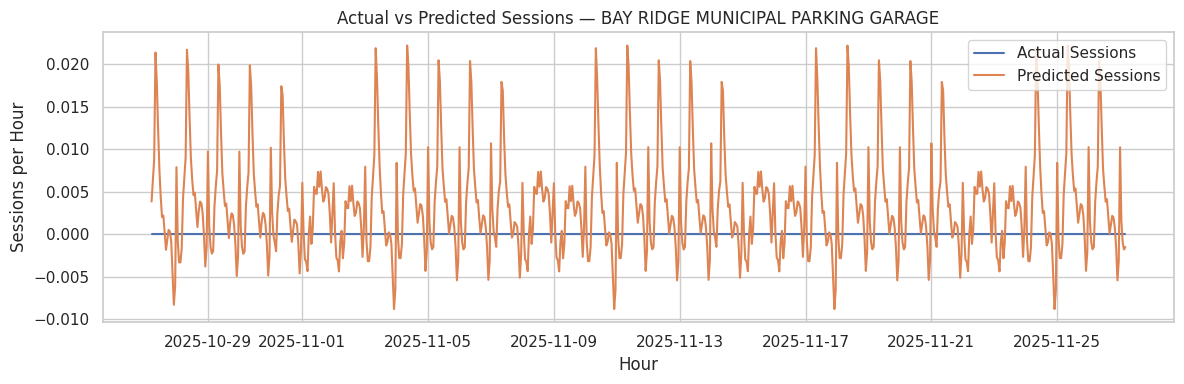

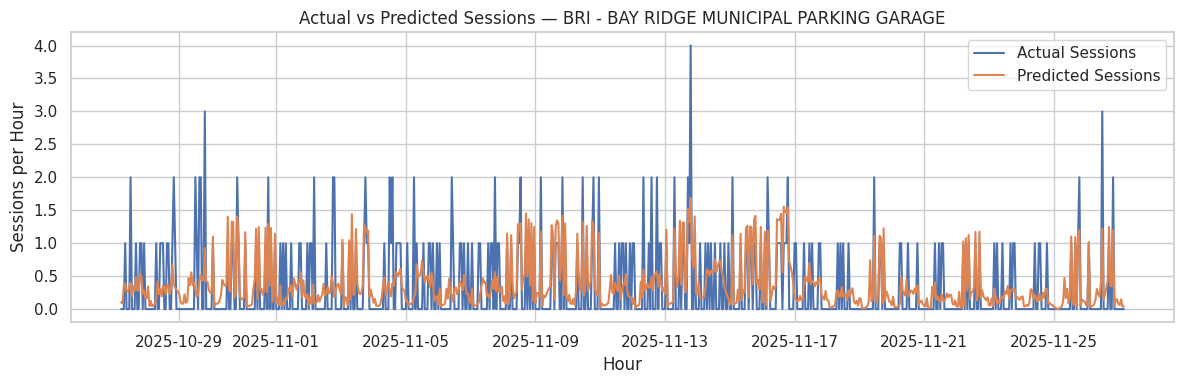

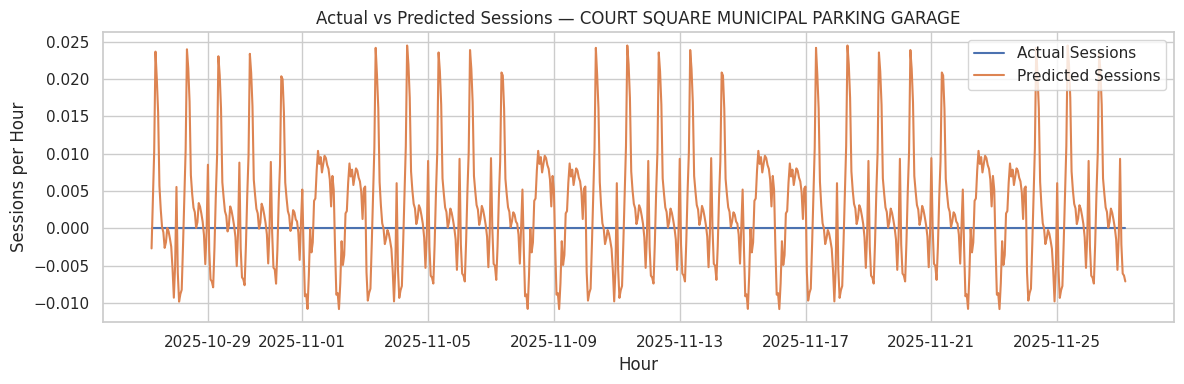

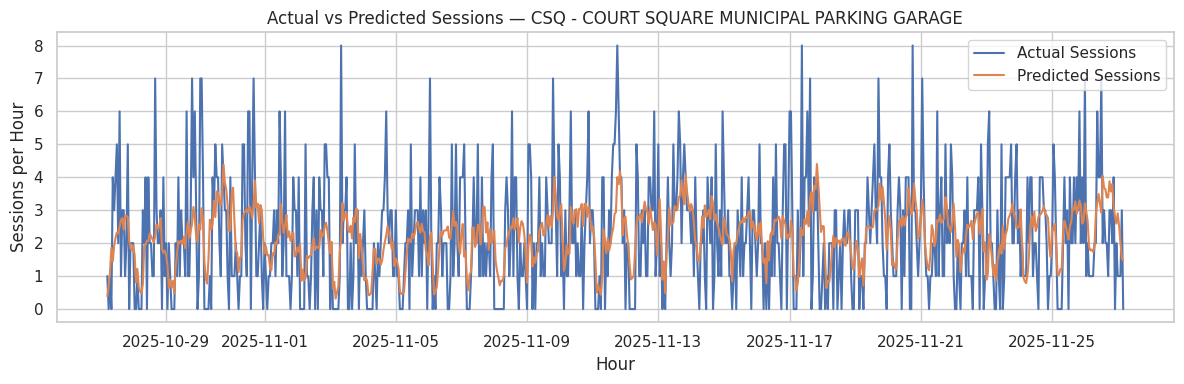

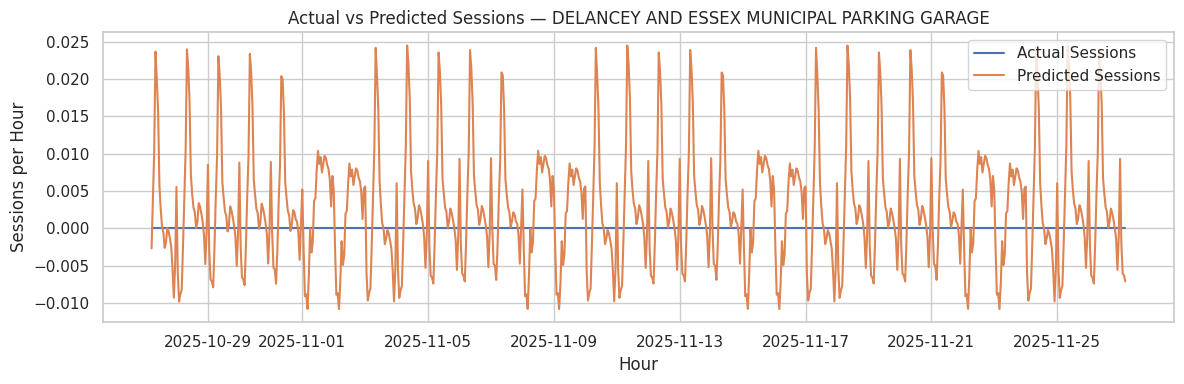

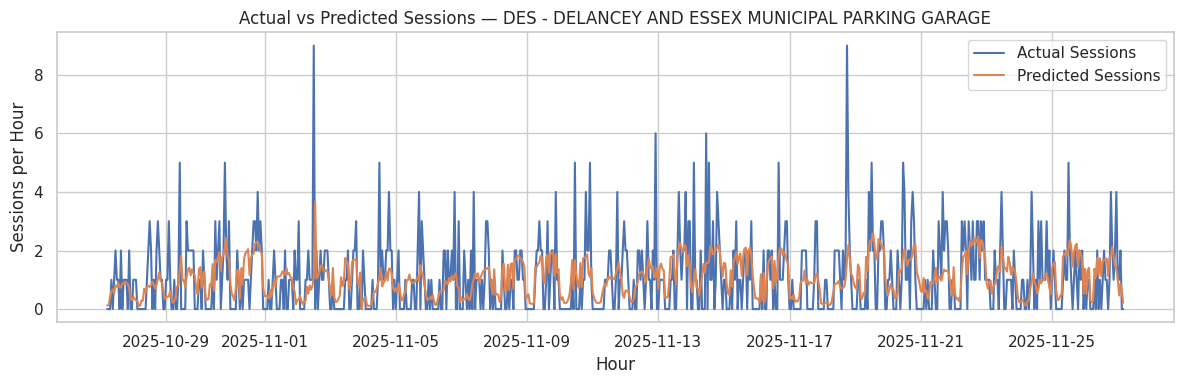

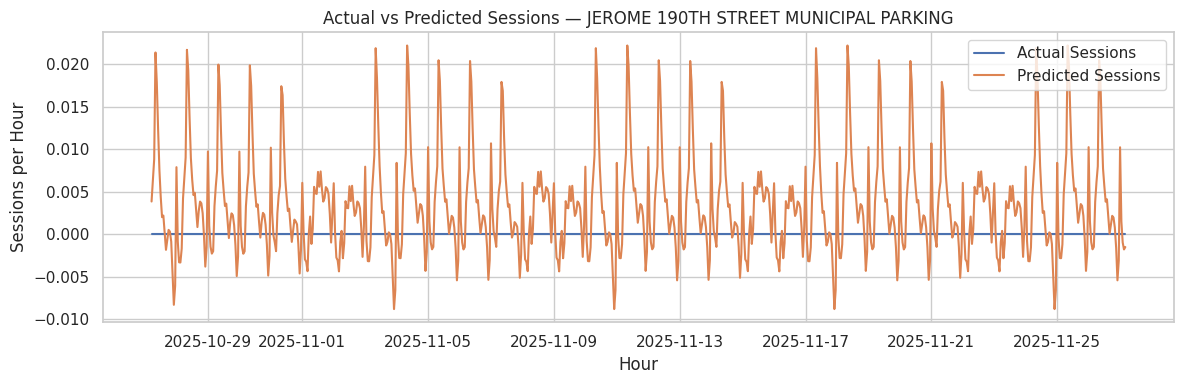

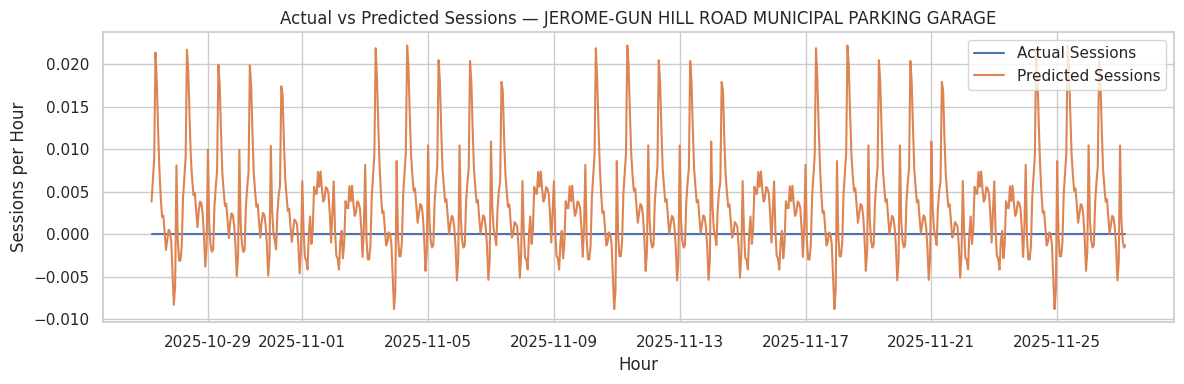

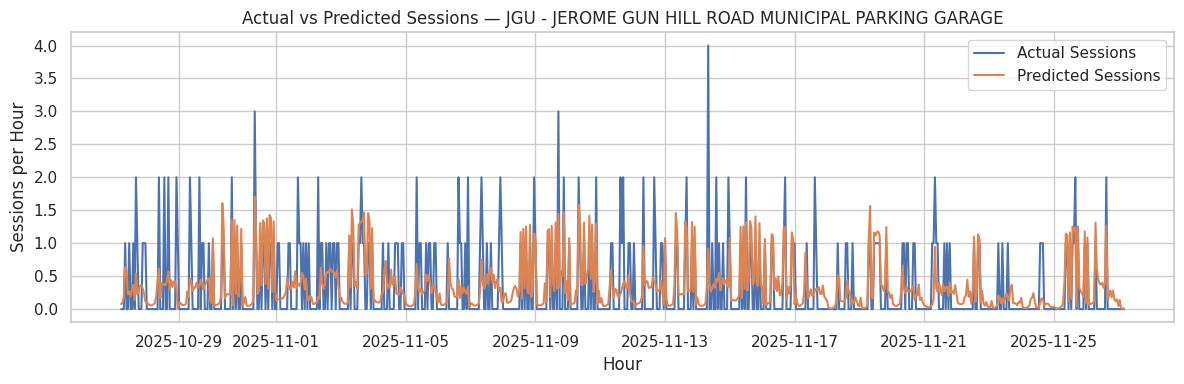

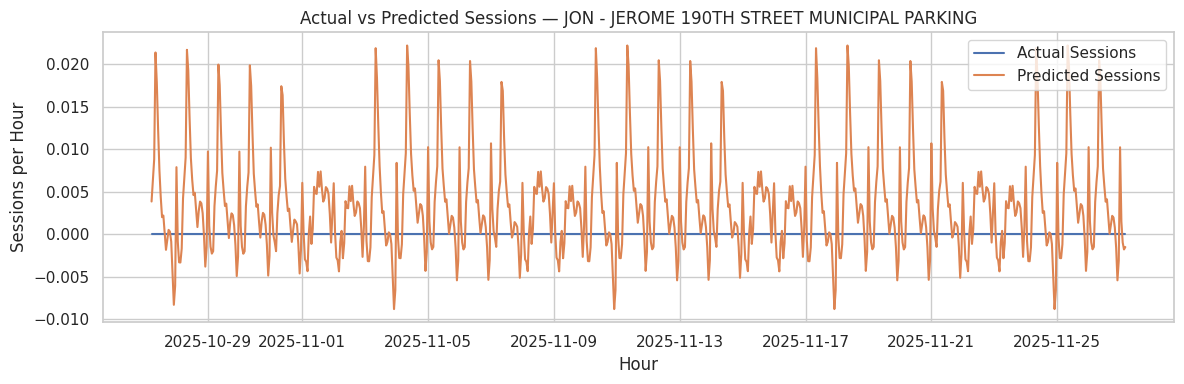

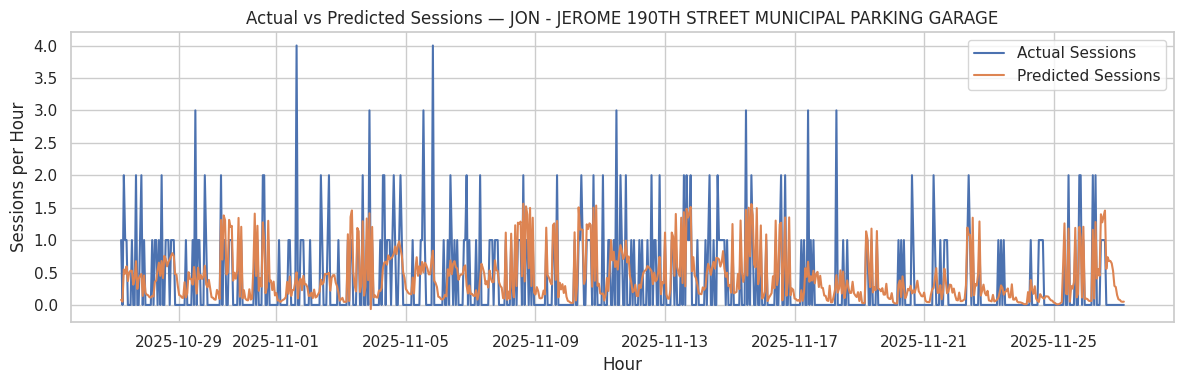

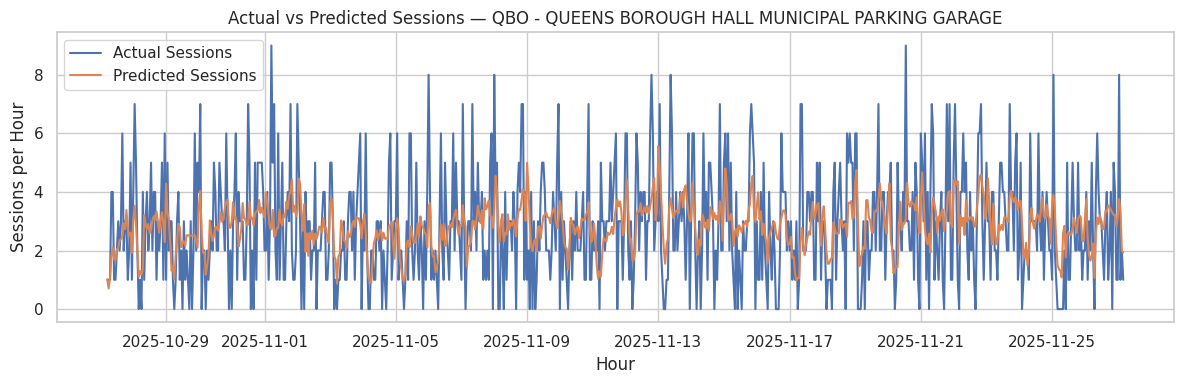

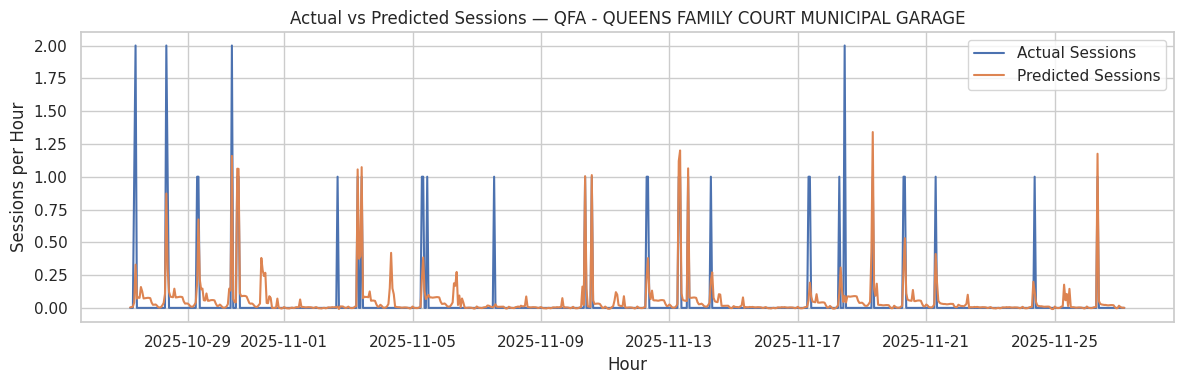

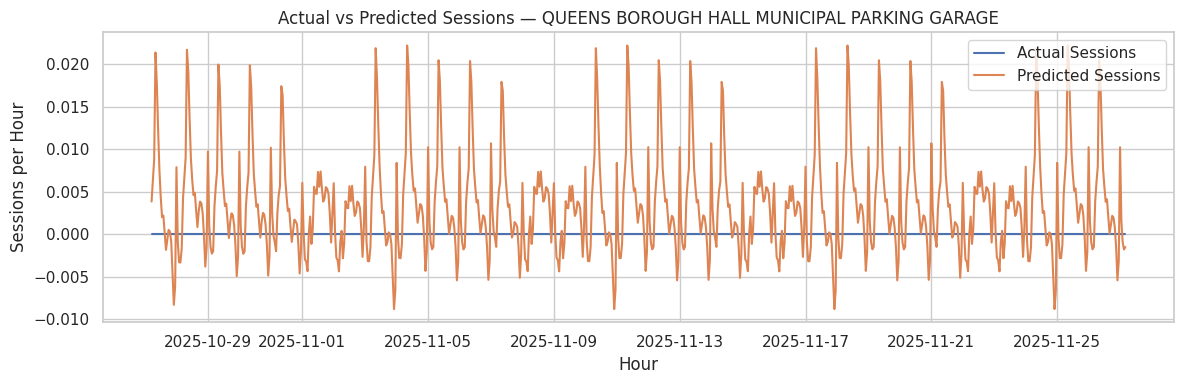

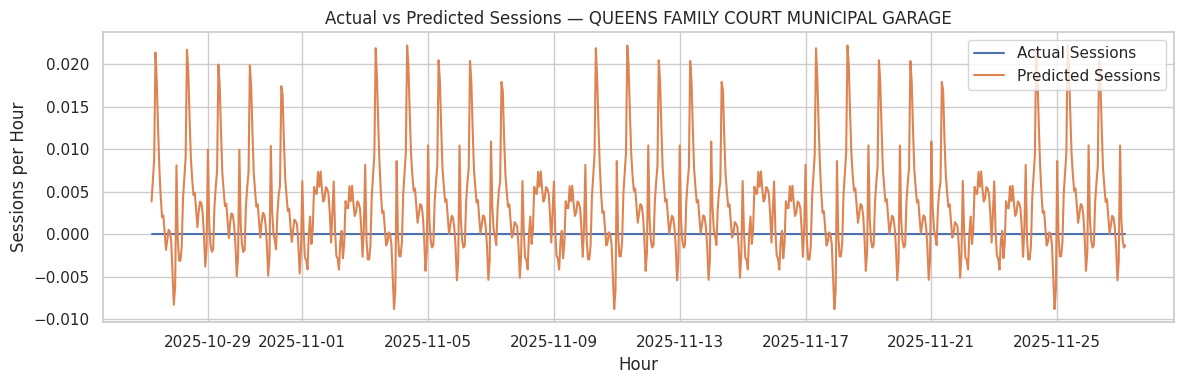

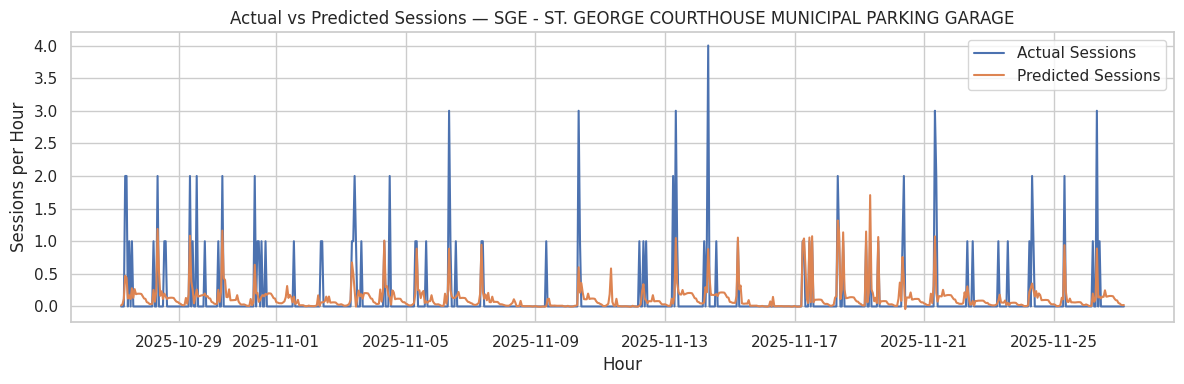

In [58]:
val_locs = valid[LOCATION_COL].unique()
max_plots = 40

for loc in val_locs[:max_plots]:
    df_loc = valid[valid[LOCATION_COL] == loc].sort_values('hour')
    if df_loc.empty:
        continue
    safe_loc = str(loc).replace('/', '_').replace('\\', '_').replace(' ', '_')[:100]

    # ---- Sessions plot ----
    plt.figure(figsize=(12, 4))
    plt.plot(df_loc['hour'], df_loc['sessions_per_hour'], label='Actual Sessions', linewidth=1.5)
    plt.plot(df_loc['hour'], df_loc['pred_sessions'], label='Predicted Sessions', linewidth=1.5)
    plt.title(f'Actual vs Predicted Sessions — {loc}')
    plt.xlabel('Hour')
    plt.ylabel('Sessions per Hour')
    plt.legend()
    plt.tight_layout()

In [59]:
last_known = hourly.groupby(LOCATION_COL).tail(1).set_index(LOCATION_COL)

# build list of forecast hours
forecast_hours = pd.date_range(start=max_hour + pd.Timedelta(hours=1), end=forecast_end - pd.Timedelta(seconds=1), freq='H')

rows = []
for fh in tqdm(forecast_hours, desc='Forecasting hours'):
    for loc in locations:
        row = {}
        row[LOCATION_COL] = loc
        row['hour'] = fh
        row['hour_of_day'] = fh.hour
        row['day_of_week'] = fh.dayofweek
        row['month'] = fh.month
        row['is_weekend'] = 1 if fh.dayofweek in [5,6] else 0

        if 'avg_temp' in last_known.columns:
            row['is_hot'] = int(last_known.loc[loc]['avg_temp'] > 30)
            row['is_cold'] = int(last_known.loc[loc]['avg_temp'] < 5)
        else:
            row['is_hot'] = 0
            row['is_cold'] = 0
        row['is_rainy'] = 0
        row['is_snow'] = 0

        # fill lag features using last_known for loc (recursive)
        for tgt in ['sessions_per_hour','energy_kwh_per_hour']:
            last_vals = last_known.loc[loc]
            row[f'{tgt}_lag1'] = last_vals[tgt] if tgt in last_vals.index else 0
            key24 = fh - pd.Timedelta(hours=24)
            # check recent forecasts
            df_recent = pd.DataFrame(rows)
            val24 = 0
            if not df_recent.empty:
                mask = (df_recent[LOCATION_COL]==loc) & (df_recent['hour']==key24)
                if mask.any():
                    val24 = df_recent.loc[mask, f'{tgt}_pred'].values[0]
                else:
                    val24 = last_vals[f'{tgt}_lag24'] if f'{tgt}_lag24' in last_vals.index else 0
            else:
                val24 = last_vals[f'{tgt}_lag24'] if f'{tgt}_lag24' in last_vals.index else 0
            row[f'{tgt}_lag24'] = val24

            # lag168 similar fallback
            key168 = fh - pd.Timedelta(hours=168)
            val168 = 0
            if not df_recent.empty:
                mask = (df_recent[LOCATION_COL]==loc) & (df_recent['hour']==key168)
                if mask.any():
                    val168 = df_recent.loc[mask, f'{tgt}_pred'].values[0]
                else:
                    val168 = last_vals[f'{tgt}_lag168'] if f'{tgt}_lag168' in last_vals.index else 0
            else:
                val168 = last_vals[f'{tgt}_lag168'] if f'{tgt}_lag168' in last_vals.index else 0
            row[f'{tgt}_lag168'] = val168

            # rolling 24: we will keep using last_known rolling value
            row[f'{tgt}_ma24'] = last_vals[f'{tgt}_ma24'] if f'{tgt}_ma24' in last_vals.index else 0

        # assemble feature vector
        feat = {k: row[k] for k in FEATURES if k in row}
        feat[LOCATION_COL] = loc
        X_row = pd.DataFrame([feat])

        # predict sessions then energy
        sess_pred = model_sessions.predict(X_row[FEATURES + [LOCATION_COL]])[0]
        energy_pred = model_energy.predict(X_row[FEATURES + [LOCATION_COL]])[0]

        # store predictions in row
        row['sessions_per_hour_pred'] = float(max(0, sess_pred))
        row['energy_kwh_per_hour_pred'] = float(max(0, energy_pred))

        # update last_known for this loc to include this predicted hour as last observation
        # create a new series-like structure
        new_series = last_known.loc[loc].copy()
        # shift lags: update lag1 to new pred, lag24, lag168 remain as sourced above
        new_series['sessions_per_hour'] = row['sessions_per_hour_pred']
        new_series['energy_kwh_per_hour'] = row['energy_kwh_per_hour_pred']
        new_series['sessions_per_hour_lag1'] = row['sessions_per_hour_pred']
        new_series['energy_kwh_per_hour_lag1'] = row['energy_kwh_per_hour_pred']
        # keep ma24 as-is (approx)
        last_known.loc[loc] = new_series

        rows.append(row)

# collect forecast dataframe
forecast_df = pd.DataFrame(rows)

Forecasting hours: 100%|██████████| 719/719 [22:12<00:00,  1.85s/it]


In [82]:
forecast_df.head(2)

,location_name,hour,hour_of_day,day_of_week,month,is_weekend,is_hot,is_cold,is_rainy,is_snow,sessions_per_hour_lag1,sessions_per_hour_lag24,sessions_per_hour_lag168,sessions_per_hour_ma24,energy_kwh_per_hour_lag1,energy_kwh_per_hour_lag24,energy_kwh_per_hour_lag168,energy_kwh_per_hour_ma24,sessions_per_hour_pred,energy_kwh_per_hour_pred
0,BAY RIDGE MUNICIPAL PARKING GARAGE,2025-11-27 05:00:00,5,3,11,0,1,0,0,0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.003797,0.035845
1,BRI - BAY RIDGE MUNICIPAL PARKING GARAGE,2025-11-27 05:00:00,5,3,11,0,1,0,0,0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,6.654875,0.053322,1.652900


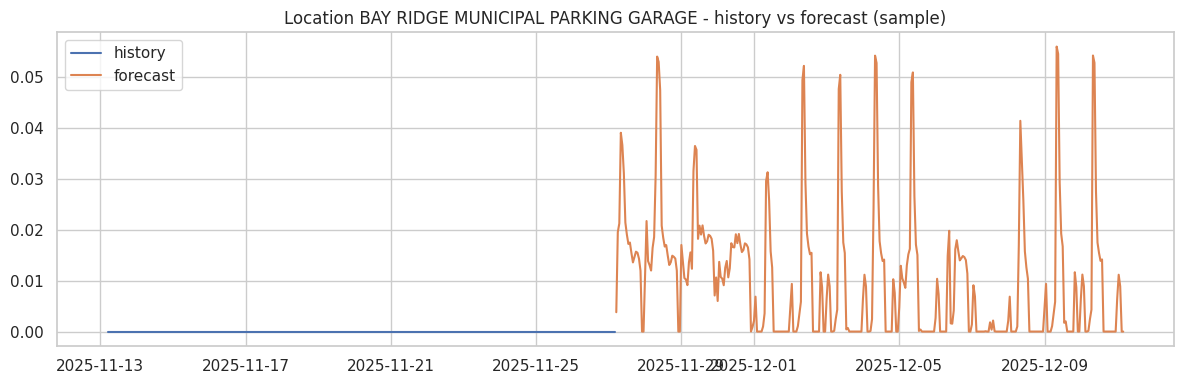

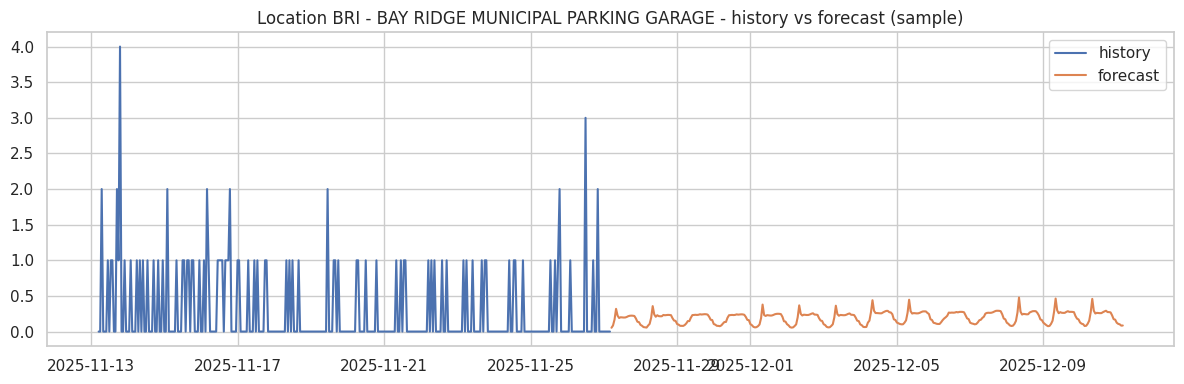

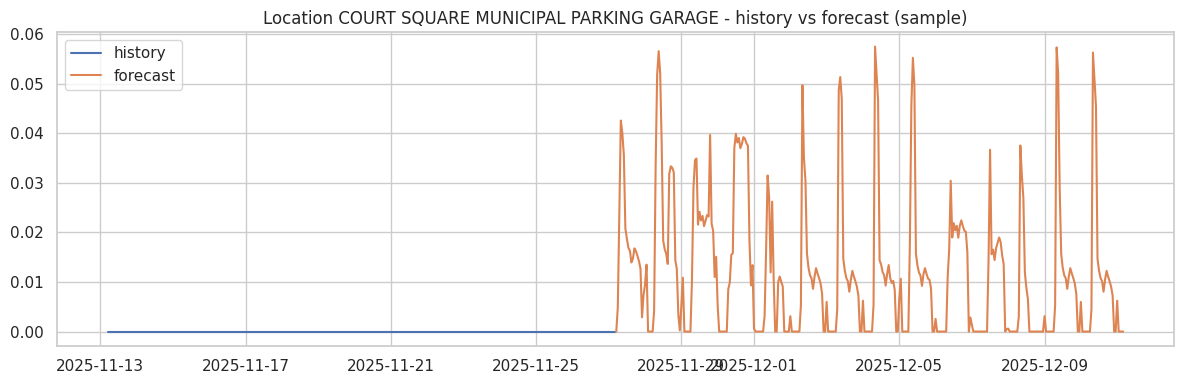

In [83]:
sample_locs = list(locations)[:3]
for loc in sample_locs:
    plt.figure(figsize=(12,4))
    hist = hourly[hourly[LOCATION_COL]==loc].set_index('hour')['sessions_per_hour']
    fut = forecast_df[forecast_df[LOCATION_COL]==loc].set_index('hour')['sessions_per_hour_pred']
    hist_last = hist.iloc[-24*14:]  # last 14 days
    fut_first = fut.iloc[:24*14]
    plt.plot(hist_last.index, hist_last.values, label='history')
    plt.plot(fut_first.index, fut_first.values, label='forecast')
    plt.title(f'Location {loc} - history vs forecast (sample)')
    plt.legend()
    plt.tight_layout()